# Analizador Descendente Recursivo

Un __analizador sintáctico descendente recursivo__ es un tipo de analizador de arriba hacia abajo construido a partir de un conjunto de mutuamente recursivos procedimientos (o un equivalente no recursiva), donde cada una de dichas procedimiento pone en práctica uno de los no terminales de la gramática . Así, la estructura del programa resultante refleja fielmente la de la gramática que reconoce.

# Implementación de una Calculadora

```
assignment ::= 'IDENT' '=' expression ';'

expression ::= term ( ('+'|'-') term )*

term ::= factor ( ('*'|'/') factor )*

factor ::= 'IDENT' | 'NUMBER' | '(' expression ')'
```

## Analizador Léxico

In [ ]:
!pip install sly
!pip install multimethod
!pip install graphviz

     |████████████████████████████████| 61kB 1.7MB/s 
  Created wheel for sly: filename=sly-0.4-cp36-none-any.whl size=27355 sha256=bb7924d8e4c2e616f8e02dd2b898beb3d74a8bcdfa0c245f0785b98299d5fa78
  Stored in directory: /root/.cache/pip/wheels/dc/a1/a5/c955c27208da560f3a83176974d81c1c7ba09a647f7832c196
Successfully built sly


In [ ]:
from sly import Lexer

class Tokenizer(Lexer):

    tokens = { IDENT, NUMBER, }
    literals = '+-*/=();^'

    ignore = ' \t'

    # Expresiones Regulares
    IDENT  = r'[a-zA-Z_][a-zA-Z0-9_]*'
    NUMBER = r'\d+(\.\d*)?([eE][-+]?\d+)?'

    def NUMBER(self, t):
        t.value = float(t.value)
        return t

    def error(self, t):
        print(f'Error Léxico: {t.value[0]}')
        self.index += 1

ModuleNotFoundError: ignored

# Estructura del AST

### Patron Visitor

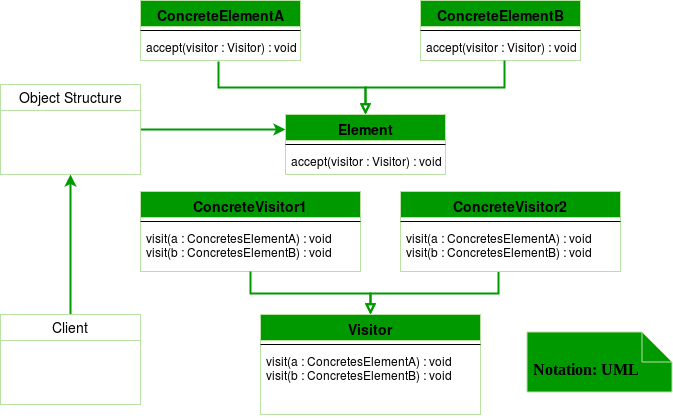

### Definición de Clases

In [ ]:
from typing import Any, List
from dataclasses import dataclass, field
from multimethod import multimeta

# clases Abstractas
class Visitor(metaclass=multimeta):
    pass

@dataclass
class Node:
    def accept(self, visitor: Visitor, *args, **kwargs):
        return visitor.visit(self, *args, **kwargs)

@dataclass
class Statement(Node):
    pass

@dataclass
class Expression(Node):
    pass

@dataclass
class Literal(Expression):
    '''
    Una Constante como 2, 2.5, 'dos', Nil, True, False
    '''
    pass

@dataclass
class Location(Node):
    pass

# Nodos Reales del AST
@dataclass
class Number(Literal):
    value : float

@dataclass
class SimpleLocation(Location):
    name : str

@dataclass
class ReadLocation(Expression):
    location : Location

@dataclass
class WriteLocation(Statement):
    location : Location
    expr     : Expression

@dataclass
class Binop(Expression):
    '''
    Operador binario como: +, -, *. /
    '''
    op    : str
    left  : Expression
    right : Expression



## Render para el AST

## Analizador Descendente Recursivo

In [ ]:
class RecursiveDescentParser(object):
    '''
    Implementacion de un Analizador descendente recursivo.
    Cada metodo implementa una sola regla de la gramatica.

    Use el metodo ._accept() para probar y aceptar el token actualmente leido.
    Use el metodo ._expect() para coincidir y descartar exactamente el token
    siguiente en la entrada (o levantar un SystemError si no coincide).

    El atributo .tok contiene el ultimo token aceptado.
    El atributo .nexttok contiene el siguiente token leido.
    '''
    # Tabla de simbolos

    operaciones = {}

    def operacion(self,nombre, expresion):
      operaciones = {nombre: expresion}

    def reoperacion(self):
      return self.operaciones

    def _continue(self):
        'Continues searching for more expressions'
        if self.nexttok:
            if self.nexttok.type == 'IDENT':
                'Entry point to parsing the next expression'
                return self.assignment()
        else:
            return False

    def assignment(self):
        '''
        assignment : [IDENT = expression ;, IDENT = expression ;, ...]
        '''
        ExpressionList = []
        if self._accept('IDENT'):
            name = self.tok.value
            self._expect('=')
            expr = self.expression()
            self._expect(';')
            #self.operacion(name, expr)
            ExpressionList.append(WriteLocation(SimpleLocation(name), expr))
            self._continue()
            return ExpressionList
        else:
            raise SyntaxError('Error de sintaxis en Asignación')

    def expression(self):
        '''
        expression : term ( ('+'|'-') term )*
        '''
        expr = self.term()
        while self._accept('+') or self._accept('-'):
            op    = self.tok.value
            right = self.term()
            expr  = Binop(op, expr, right)

        return expr



    def term(self):
        '''
        term : factor ( ('*'|'/'|'^') factor )*
        '''
        term = self.factor()
        while self._accept('*') or self._accept('/') or self._accept('^'):
            op    = self.tok.value
            right = self.factor()
            term  = Binop(op, term, right)

        return term

    def factor(self):
        '''
        factor : IDENT | NUMBER | ( expression )
        '''
        if self._accept('IDENT'):
            return ReadLocation(SimpleLocation(self.tok.value))

        elif self._accept('NUMBER'):
            return Number(self.tok.value)

        elif self._accept('('):
            expr = self.expression()
            self._expect(')')
            return expr

        else:
            raise SyntaxError('Error de sintaxis en factor')


    # -----------------------------------------
    # Funciones de Utilidad.  No cambie nada
    #
    def _advance(self):
        'Advanced the tokenizer by one symbol'
        self.tok, self.nexttok = self.nexttok, next(self.tokens, None) + next(self.tokens,None)

    def _accept(self, toktype):
        'Consume the next token if it matches an expected type'
        if self.nexttok and self.nexttok.type == toktype:
            self._advance()
            return True
        else:
            return False

    def _expect(self, toktype):
        'Consume and discard the next token or raise SyntaxError'
        if not self._accept(toktype):
            raise SyntaxError("Expected %s" % toktype)

    def start(self):
        'Entry point to parsing'
        self._advance()              # Load first lookahead token
        return self.assignment()

    def parse(self, tokens):
        'Entry point to parsing'
        self.tok = None         # Last symbol consumed
        self.nexttok = None     # Next symbol tokenized
        self.tokens = tokens
        return self.start()

In [ ]:
text   = "a = 4+2;y=5+2;"

lexer  = Tokenizer()
parser = RecursiveDescentParser()

ast = parser.parse(lexer.tokenize(text))

ast

[WriteLocation(location=SimpleLocation(name='a'), expr=Binop(op='+', left=Number(value=4.0), right=Number(value=2.0)))]

In [ ]:
from graphviz import Digraph

class ASTRender(Visitor):
    '''
    Crea archivo tipo 'dot' para Graphiz
    '''
    _node_defaults = {
        'shape': 'box',
        'color': 'lightblue2',
        'style': 'filled'
    }




    def operacion(valor1,valor2,operacion):

        if operacion == '+':
          resultado = valor1 + valor2
        elif operacion == '-':
          resultado = valor1 - valor2
        elif operacion == '/':
          resultado = valor1 / valor2
        elif operacion == '*':
          resultado = valor1 * valor2
        elif operacion == '^':
          resultado = valor1 ** valor2
        return resultado


    _edge_defaults = { }


    def __init__(self):
        '''
        creamos un obj del tipo dot que se va a llamar AST
        '''
        self.dot = Digraph('AST', comment='AST para Calculadora')
        self.dot.attr('node', **self._node_defaults)
        self.dot.attr('edge', **self._edge_defaults)
        self.id =0

    @classmethod
    def render(cls, model):
        renderer = cls()
        model.accept(renderer)

    def __repr__(self):
        return self.dot

    def _id(self):
        self.id += 1
        return 'n%02d' % self.id

    def visit(self, node):
        assignaciones = {}
        resultado = 0



    def visit(self, node: Binop):
        name = self._id()
        label = 'binop\nop: {}'.format(node.op)
        self.dot.node(name, label)
        self.dot.edge(name, self.visit(node.left))
        self.dot.edge(name, self.visit(node.right))
        return name

    def visit(self, node: WriteLocation):
        name = self._id()
        label = 'assign'
        self.dot.node(name, label)
        self.dot.edge(name, self.visit(node.location))
        self.dot.edge(name, self.visit(node.expr))
        return name

    def visit(self, node: Number):
        name = self._id()
        label = 'constant\nvalue: {}'.format(node.value)
        self.dot.node(name, label, color='yellow')   # color amarillo
        return name

    def visit(self, node: SimpleLocation):
        name = self._id()
        assignaciones[node.name] = 0
        label = 'variable\nname: {}'.format(node.name)
        self.dot.node(name, label, color='limegreen')
        return name

In [ ]:
dot = ASTRender()
for i in ast:
  i.accept(dot)
ast[0]

NameError: ignored

## Taller

1. Agregar el operador `^` (potencia) con la misma precedencia de `*` y `/`
2. Crear un visitante para evaluar la expresión aritmética
3. Modificar la gramática para aceptar varias lineas de asignación y realizar la siguiente entrada (calcular pi):

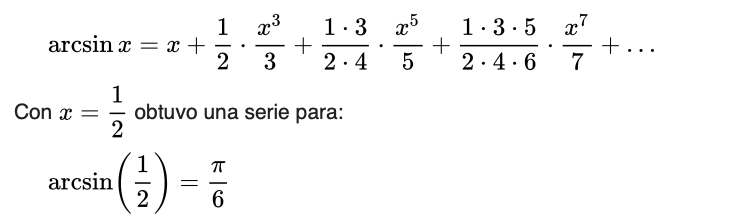